# Modeling Notebook

This notebook will contain models and model iterations and is an extension of the first notebook 01_mc_explore. That one was a bit messy as I was trying to get used to working with time series. 

### Plan
- Recreate baseline model for all 10 zip codes
- Make TS's stationary
- Model iterations

Along with modeling I will also try to create visualizations to use in our initial viz presentation.

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error as mse

%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Now that the libraries are imported, I can import the data into a pandas dataframe.

In [6]:
df = pd.read_csv('../../data/zillow_data.csv')

From the initial exploratory notebook, these are the zip codes I am to analyze and model

In [7]:
regions = [60639, 60160, 60409, 60520, 60073, 60406, 60110, 60153, 60804, 60403]

In [8]:
regions_df = mcf.melt_data(df[df['RegionName'].isin(regions)])

In [9]:
regions_df.set_index('time', inplace=True)

In [10]:
train_dfs = []
test_dfs = []
for region in regions:
    train, test = mcf.train_test_split(df, region, '2013-01-01', '2017-10-01', '2017-10-01')
    train_dfs.append(train)
    test_dfs.append(test)

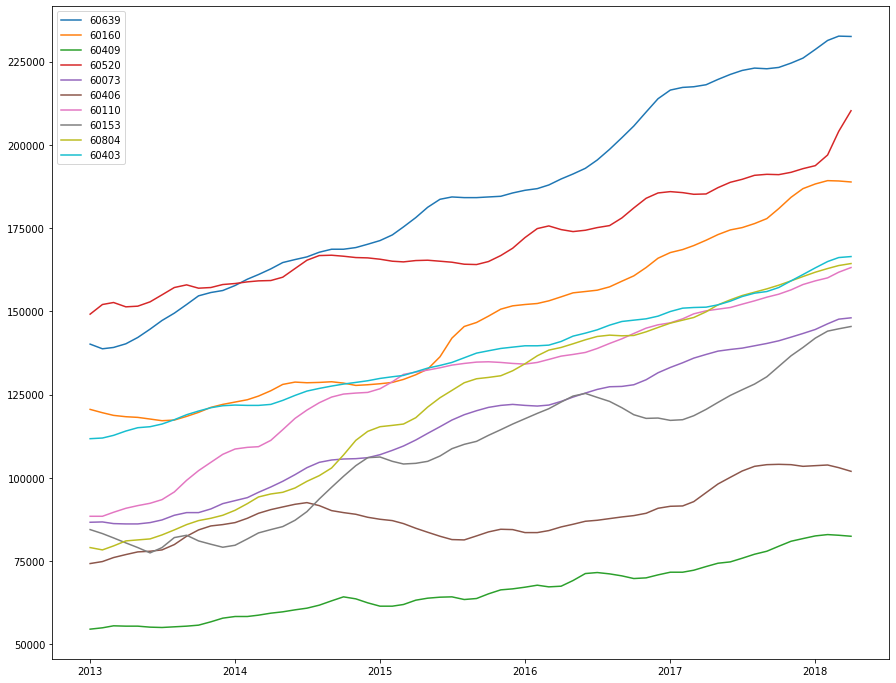

In [11]:
fig, ax = plt.subplots(figsize=(15, 12))
for region in regions:
    ax.plot(regions_df[regions_df['RegionName']==region]['2013-01-01':]['value'], label=region)

ax.legend(loc='best')

All of these zip codes show an upward trend. Zip code 60406 has a subtle decrease in the middle of the trend. A few of the zip codes have a little bit of noise. I need to make these stationary after I recreate a baseline random walk model for each zip code.

### Baseline (random walk) model

Just as I stated in the first notebook, I could create a random walk model simply by performing a first order differencing on the series. However, when I use the ARIMA model, I get a more interpretable model, so that's the way I am going to do it.

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa

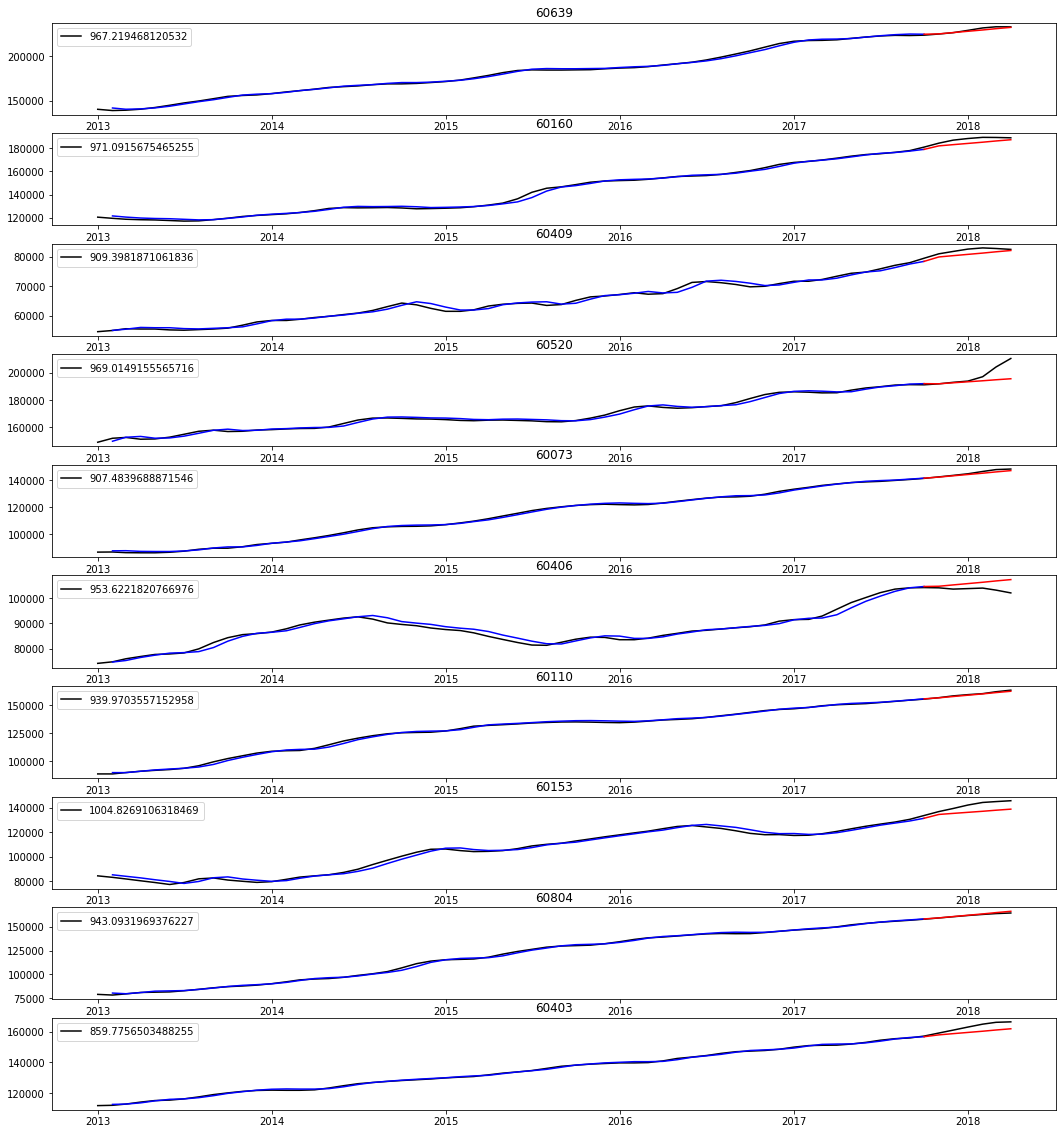

In [12]:
fig, ax = plt.subplots(10, figsize=(18,20))
aic = []
for i in range(len(regions)):
    rw = ARIMA(train_dfs[i], (0, 1, 0)).fit()
    aic.append(rw.aic)
    train_predict = rw.predict(typ='levels')
    test_predict = rw.predict(start=test_dfs[i].index[0], end=test_dfs[i].index[-1], typ='levels')
    ax[i].plot(regions_df[regions_df['RegionName']==regions[i]]['2013-01-01':]['value'], color='black', label=rw.aic)
    ax[i].plot(train_predict, color='blue')
    ax[i].plot(test_predict, color='red')
    ax[i].set_title(regions[i])
    ax[i].legend()
print('Average AIC: {}'.format(np.mean(aic)))

The basic random walk model actually performed really well for all of the zip codes. For all except 1, the AIC score was under 1,000. And overall the ten random walk models had an average AIC of 942.5, that's great for a baseline model. 


In [13]:
rw_60639 = ARIMA(train_dfs[0], (0, 1, 0)).fit()

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [89]:
rw_60639.aic

967.219468120532

Text(0, 0.5, 'Value')

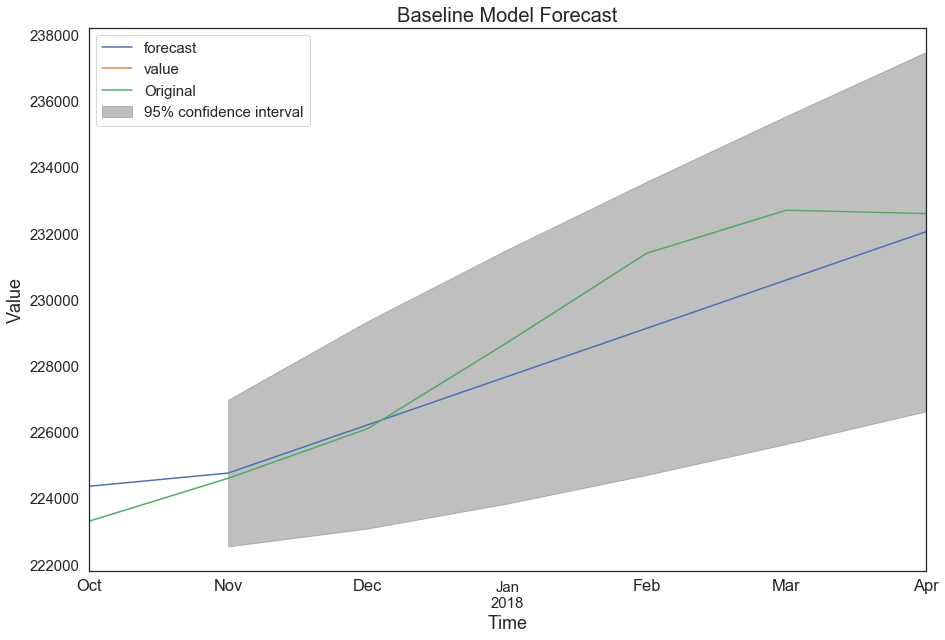

In [53]:
fig, ax = plt.subplots(figsize=(15,10))
rw_60639.plot_predict(start='2017-10-01', end='2018-04-01', ax=ax);
test_dfs[0].plot(ax=ax, label='Original')
ax.legend(loc='upper left', prop={'size': 15})
ax.set_title('Baseline Model Forecast', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Value')

In [15]:
train_preds = rw_60639.predict(typ='levels')
test_preds = rw_60639.predict(start=test_dfs[0].index[0], end=test_dfs[0].index[-1], typ='levels')

In [16]:
import seaborn as sns

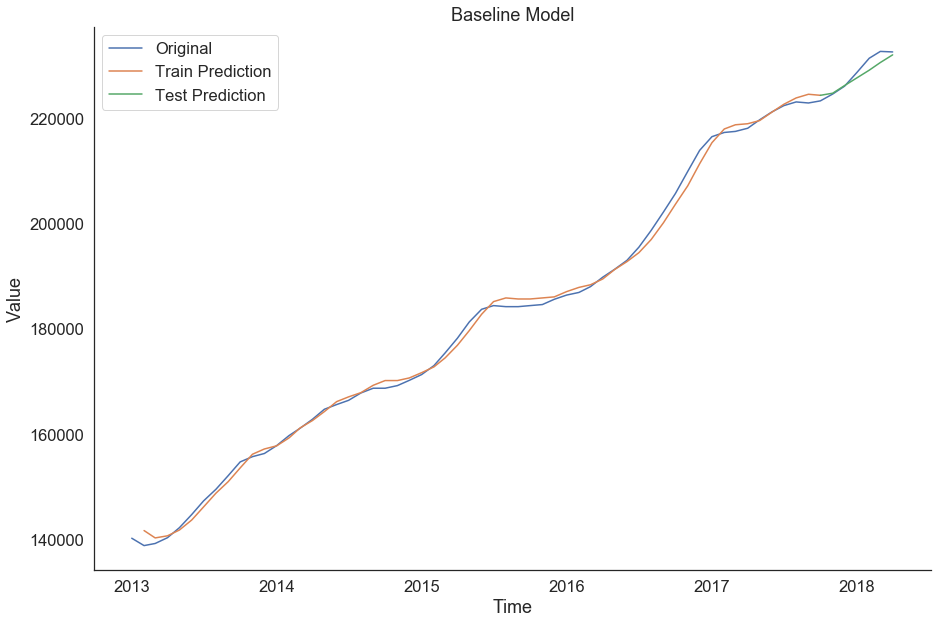

In [34]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})
splot = sns.lineplot(x=regions_df[regions_df['RegionName'] == 60639]['2013-01-01':].index, y=regions_df[regions_df['RegionName'] == 60639]['2013-01-01':]['value'].values, label='Original')
sns.lineplot(x=train_dfs[0]['2013-02-01':].index, y=train_preds, label='Train Prediction')
sns.lineplot(x=test_dfs[0].index, y=test_preds, label='Test Prediction')
splot.set_title('Baseline Model')
splot.set_xlabel('Time')
splot.set_ylabel('Value')
splot.legend(loc='best')
sns.despine()

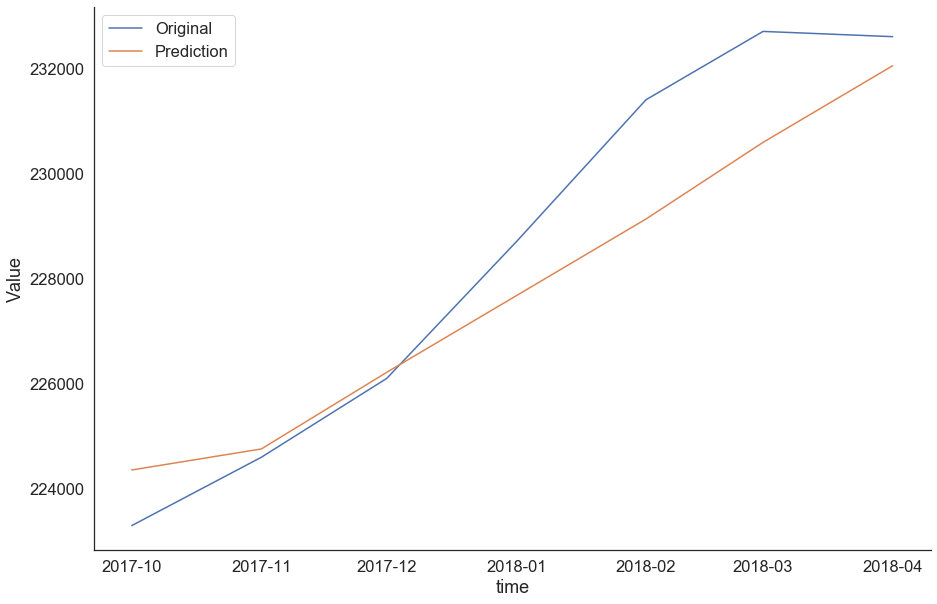

In [85]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})
plot = sns.lineplot(x=regions_df[regions_df['RegionName'] == 60639]['2017-10-01':].index, y=regions_df[regions_df['RegionName'] == 60639]['2017-10-01':]['value'].values, label='Original')
sns.lineplot(x=test_dfs[0].index, y=test_preds, label='Prediction')
# plot.set_title('Baseline Model Testing Accuracy')
plot.set_ylabel('Value')
sns.despine()
plt.legend(loc='best');

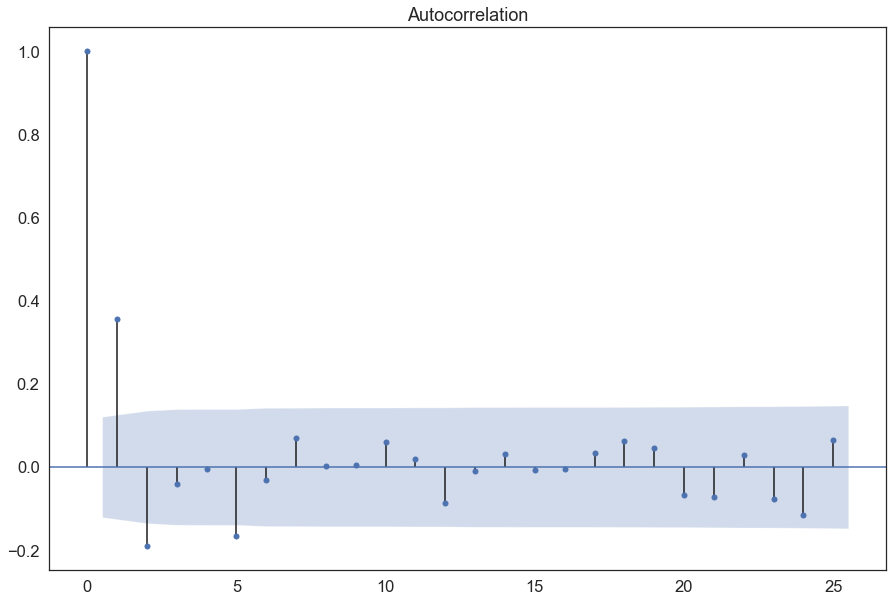

In [19]:
plot_acf(regions_df[regions_df['RegionName'] == 60639]['value'].diff().diff().dropna());

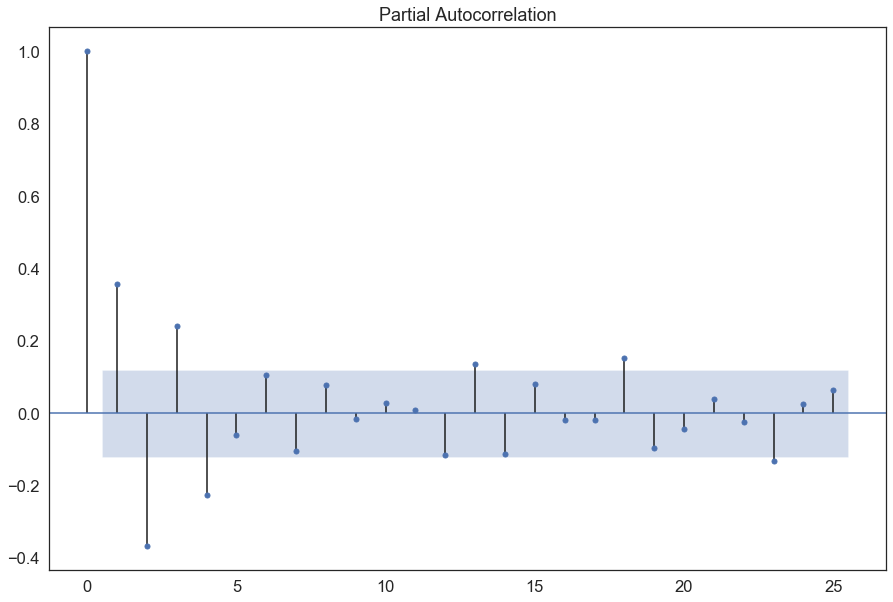

In [20]:
plot_pacf(regions_df[regions_df['RegionName'] == 60639]['value'].diff().diff().dropna());

In [21]:
model2 = ARIMA(train_dfs[1], (1, 2, 1)).fit()

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [22]:
model2.aic

899.4727033698218

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
decomp = seasonal_decompose(train_dfs[0])

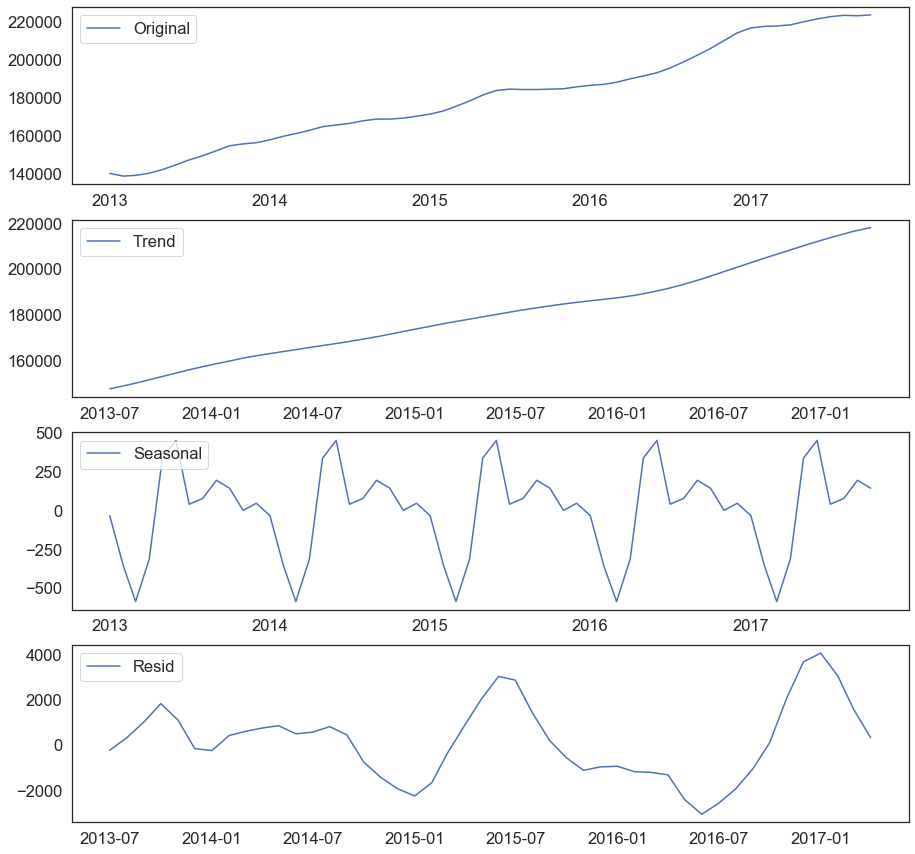

In [88]:
fig, ax = plt.subplots(4, figsize=(15, 15))
ax[0].plot(train_dfs[0], label='Original')
ax[1].plot(decomp.trend, label='Trend')
ax[2].plot(decomp.seasonal, label='Seasonal')
ax[3].plot(decomp.resid, label='Resid')
ax[0].legend()
ax[1].legend()
ax[2].legend(loc='upper left')
ax[3].legend()

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [86]:
smodel = SARIMAX(train_dfs[0], order=(2,1,1),seasonal_order=(2,1, 1, 12),
                            enforce_stationarity=False, enforce_invertibility=False).fit()

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [87]:
smodel.aic

312.432036106501

In [71]:
smax_train_pred = smodel.predict(typ='levels')

In [75]:
smax_test_pred = smodel.predict(start='2017-10-01', end='2018-04-01', typ='levels')

In [76]:
mse(train_dfs[0], smax_train_pred)

668754513.4653515

In [77]:
mse(test_dfs[0], smax_test_pred)

1079035.5849065515

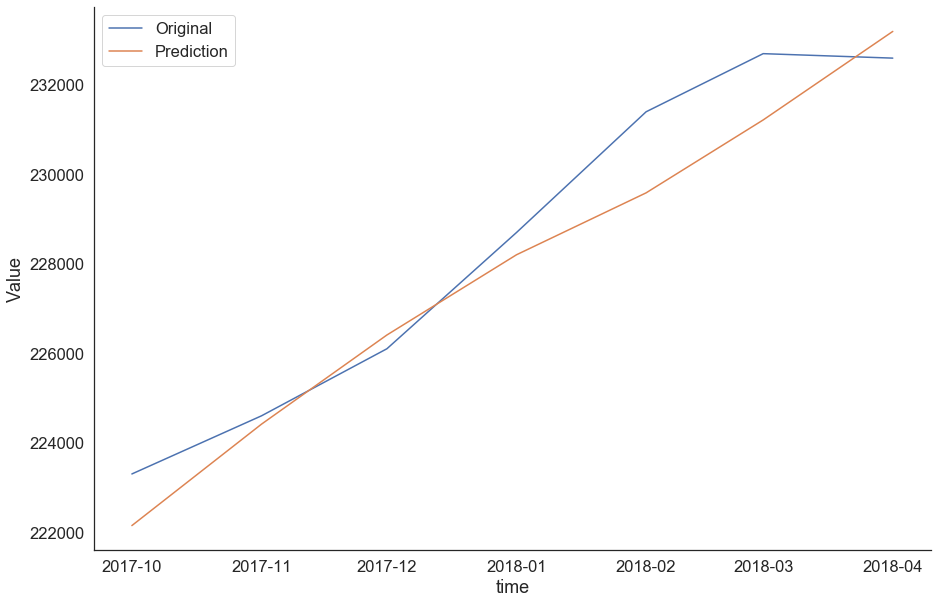

In [90]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})
plot = sns.lineplot(x=regions_df[regions_df['RegionName'] == 60639]['2017-10-01':].index, y=regions_df[regions_df['RegionName'] == 60639]['2017-10-01':]['value'].values, label='Original')
sns.lineplot(x=test_dfs[0].index, y=smax_test_pred, label='Prediction')
# plot.set_title('SARIMAX Model Testing Accuracy')
plot.set_ylabel('Value')
sns.despine()
plt.legend(loc='best');

All of the plots above were used for the mid-week viz presentation. 

After more consideration we are thinking of subsetting for city=Chicago rather than metro=Chicago. This would exclude the Chicago suburbs but we want to do a map of the Chicago zip codes.

In [122]:
chicago2 = df[df['City'] == 'Chicago']

In [123]:
chicago2['5yrROI'] = ((chicago2['2018-04'] - chicago2['2013-04'])/chicago2['2013-04']) * 100

In [125]:
chicago2.sort_values('5yrROI', ascending=False)[:21]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,5yrROI
1496,84648,60651,Chicago,IL,Chicago,Cook,1497,74700.0,75100.0,75400.0,...,136100,137300,139600,141800,142900,145200,148300,150300,150900,76.079347
658,84639,60639,Chicago,IL,Chicago,Cook,659,111200.0,111900.0,112300.0,...,223100,222900,223300,224600,226100,228700,231400,232700,232600,65.787598
332,84641,60641,Chicago,IL,Chicago,Cook,333,135700.0,136200.0,136400.0,...,282300,283400,284900,286100,286900,288300,289800,291000,291500,57.908992
2360,84614,60612,Chicago,IL,Chicago,Cook,2361,100900.0,101400.0,101900.0,...,359300,358700,358500,358500,355200,353400,352300,349000,345400,53.102837
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,461400,464300,466500,467900,470600,474500,475100,472600,470200,48.234552
1012,84633,60632,Chicago,IL,Chicago,Cook,1013,99600.0,100100.0,100400.0,...,163300,163200,163800,164000,164300,164700,165200,166100,166700,48.046181
318,84624,60622,Chicago,IL,Chicago,Cook,319,217000.0,216900.0,216900.0,...,794900,807000,813400,816200,816300,819300,819700,815400,811100,47.660659
157,84635,60634,Chicago,IL,Chicago,Cook,158,146800.0,147700.0,148300.0,...,255600,256400,257000,257600,258600,260500,262400,265100,267600,47.113799
497,84610,60608,Chicago,IL,Chicago,Cook,498,89800.0,89800.0,89800.0,...,233700,231600,230000,229800,230100,231100,233700,235700,236000,45.320197
48,84630,60629,Chicago,IL,Chicago,Cook,49,93400.0,94100.0,94600.0,...,158600,159500,160600,161700,162600,163500,164000,164000,163800,43.056769
